# Using a Modflow UZF model as a stressmodel in Pastas

In [1]:
import os

import flopy
import pandas as pd
import pastas as ps

import pastas_plugins.modflow as ppmf

ps.set_log_level("ERROR")

bindir = "bin"
mf6_exe = os.path.join(bindir, "mf6")
if not os.path.isfile(mf6_exe):
    if not os.path.isdir(bindir):
        os.makedirs(bindir)
    flopy.utils.get_modflow("bin", repo="modflow6")

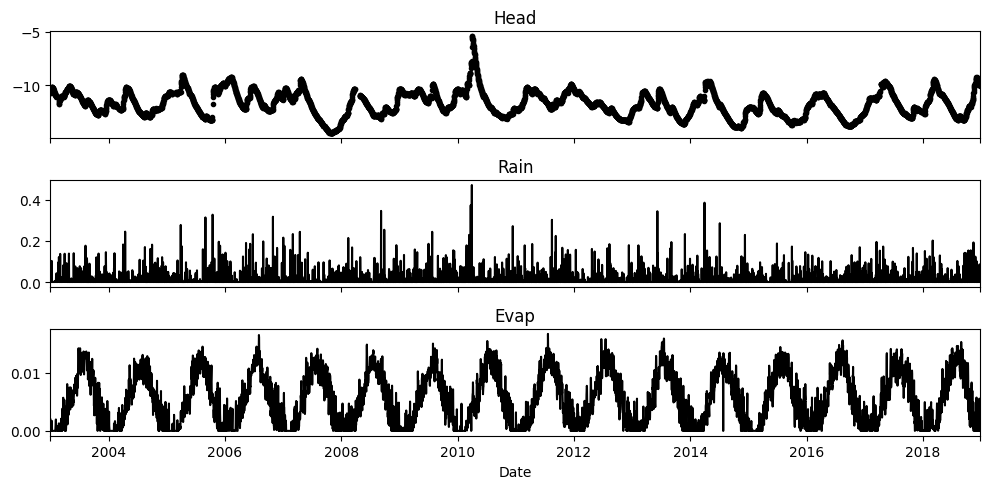

In [2]:
# %%
tmin = pd.Timestamp("2001-01-01")
tmax = pd.Timestamp("2014-12-31")

tmin_wu = tmin - pd.Timedelta(days=3651)
tmin_wu = pd.Timestamp("1986-01-01")

# ds = ps.load_dataset("collenteur_2019")
# head = ds["head"].squeeze()
# prec = ds["rain"].squeeze().resample("D").asfreq().fillna(0.0)
# evap = ds["evap"].squeeze()

head = pd.read_csv("data/obs.csv", index_col=0, parse_dates=True).squeeze()
prec = pd.read_csv("data/rain.csv", index_col=0, parse_dates=True).squeeze().resample("D").asfreq().fillna(0.0)
evap = pd.read_csv("data/evap.csv", index_col=0, parse_dates=True).squeeze()

ps.plots.series(head, [prec, evap], hist=False);

ModflowError: model run failed with parameters: (-14.23, 340.0, 0.27, 3.0, 1.0, 0.1, 0.3, 5.0, 0.5)


<Axes: xlabel='Date'>

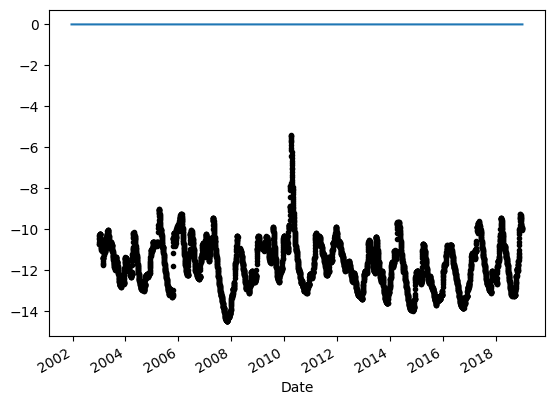

In [16]:
# create modflow pastas model with c and sy
mlumf = ps.Model(head)
constant_d = -14.23
# shorten the warmup to speed up the modflow calculation somewhat.
mlumf.settings["warmup"] = pd.Timedelta(days=4 * 365)
expmf = ppmf.ModflowUzf(exe_name=mf6_exe, sim_ws="mf_files/test_umf", head=head, nwavesets=100, ntrailwaves=7)
expsm = ppmf.ModflowModel(prec=prec, evap=evap, modflow=expmf, name="test_expmfsm")
mlumf.add_stressmodel(expsm)
mlumf.set_parameter(f"{expsm.name}_s", initial=0.27, vary=False)
mlumf.set_parameter(f"{expsm.name}_c", initial=340.0, vary=False)
# mlexpmf.set_parameter(f"{expsm.name}_f", initial=mlexp_f, vary=False)
if "constant_d" in mlumf.parameters.index:
    mlumf.set_parameter("constant_d", initial=constant_d, vary=False)
    if expmf._head is not None:
        mlumf.del_constant()
        mlumf.set_parameter(f"{expsm.name}_d", initial=constant_d, vary=False)
# height = (head.max() - constant_d)+2.0
height = 3.0
mlumf.set_parameter(f"{expsm.name}_height", initial=height, vary=False)

sim = mlumf.simulate()
ax = mlumf.observations().plot(marker=".", color="k", linestyle="None", legend=False)
sim.plot(ax=ax)